### 1. ライブラリ・関数の読み込み


In [1]:
# install.packages(c("Matrix", "MatrixExtra", "recommenderlab", "cmfrec", "ggplot2", "reshape2", "viridis", "gridExtra"))
library(cmfrec)
library(dplyr)
library(Matrix)
library(MatrixExtra)
library(recommenderlab)
library(cmfrec)
library(ggplot2)
library(reshape2)
library(viridis)
library(gridExtra)
source("cmf.R")



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


'MatrixExtra' modifies important behaviors from 'Matrix'. See ?MatrixExtra-options.

Loading required package: arules


Attaching package: 'arules'


The following object is masked from 'package:dplyr':

    recode


The following objects are masked from 'package:base':

    abbreviate, write


Loading required package: proxy


Attaching package: 'proxy'


The following object is masked from 'package:Matrix':

    as.matrix


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy

Loading required package: viridisLite


Attaching package: 'gridExtra'


The following 

### 2. データの読み込み


In [2]:
brvehins <- load_bravehins(cas_dataset_path = "/Users/nanakato/projects/CASdatasets/data")
brvehins <- brvehins[grepl("Honda", brvehins$VehModel), ]
claim_types <- c("ClaimAmountRob", "ClaimAmountPartColl", "ClaimAmountTotColl", "ClaimAmountFire", "ClaimAmountOther")
brvehins[, "ClaimTotal"] <- rowSums(brvehins[, claim_types])
str(brvehins)

# write.csv(brvehins, file = "data/brvehins_org.csv", row.names = FALSE)


'data.frame':	81115 obs. of  24 variables:
 $ Gender             : Factor w/ 3 levels "Corporate","Female",..: 1 2 3 2 3 1 3 2 3 2 ...
 $ DrivAge            : Factor w/ 5 levels ">55","18-25",..: NA 4 4 3 1 NA 5 5 4 5 ...
 $ VehYear            : int  2006 2006 2007 2011 1995 2009 2004 2006 2010 2005 ...
 $ VehModel           : Factor w/ 4259 levels "Acura - Legend 3.2/3.5",..: 1754 1752 1728 1794 1799 1787 1775 1783 1780 1765 ...
 $ VehGroup           : Factor w/ 436 levels "Acura","Agrale - Marrua",..: 216 216 215 214 215 213 212 213 212 212 ...
 $ Area               : Factor w/ 40 levels "Acre","Alagoas",..: 40 13 19 30 30 24 4 24 30 20 ...
 $ State              : Factor w/ 27 levels "Acre","Alagoas",..: 25 25 16 25 25 13 4 13 25 25 ...
 $ StateAb            : Factor w/ 27 levels "AC","AL","AM",..: 26 26 18 26 26 11 3 11 26 26 ...
 $ ExposTotal         : num  1.51 0.5 0.5 0.1 0.5 ...
 $ ExposFireRob       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ PremTotal          : num  981.8 227.3 501.2 9

### 3. データの下処理


In [3]:
# category_to_analyze <- c("Gender", "DrivAge")
# category_to_analyze <- c("VehGroup", "VehYear")
category_to_analyze <- c("VehModel", "Area")

# 型だけに注目するよりもセル自体に注目した方が良いと思った

premium_total <- get_total(brvehins, category_to_analyze, "PremTotal", 0)
exposure_total <- get_total(brvehins, category_to_analyze, "ExposTotal", 100)
claim_total <- get_total(brvehins, category_to_analyze, "ClaimTotal")

claim_total <- claim_total[rowSums(exposure_total, na.rm = TRUE) > 10, ]
premium_total <- premium_total[rowSums(exposure_total, na.rm = TRUE) > 10, ]
exposure_total <- exposure_total[rowSums(exposure_total, na.rm = TRUE) > 10, ]

weight <- exposure_total
weight[is.na(weight)] <- 0

# write.csv(exposure_total, "exposure_total.csv")
# write.csv(claim_total, "claim_total.csv")

# 純率にするか損害率にするかは要相談
# pure_premium <- premium_total / exposure_total
pure_premium <- claim_total / exposure_total
loss_ratio <- claim_total / premium_total

# write.csv(pure_premium, "pure_premium.csv")
# write.csv(loss_ratio, "loss_ratio.csv")


aggregate_col: PremTotal   group_cols: VehModelArea



[1] 125  40


aggregate_col: ExposTotal   group_cols: VehModelArea



[1] 125  40


aggregate_col: ClaimTotal   group_cols: VehModelArea



[1] 125  40


### 4. ハイパーパラメータの最適化


In [4]:
options(warn = -1)
best_params <- optimize_params(
    X = pure_premium,
    n_folds = 4,
    k_values = c(2, 5, 10, 15, 20),
    lambda_values = c(0.01, 0.1, 1, 10)
)
print(best_params)


[1] "k: 2 lambda: 0.01 CV RMSE: 954.083945750231"
[1] "k: 2 lambda: 0.1 CV RMSE: 1712.36948376564"
[1] "k: 2 lambda: 1 CV RMSE: 1365.75188464976"
[1] "k: 2 lambda: 10 CV RMSE: 812.547414073806"
[1] "k: 5 lambda: 0.01 CV RMSE: 2510.09290409067"
[1] "k: 5 lambda: 0.1 CV RMSE: 1340.84816071535"
[1] "k: 5 lambda: 1 CV RMSE: 1303.55950855333"
[1] "k: 5 lambda: 10 CV RMSE: 546.297421026159"
[1] "k: 10 lambda: 0.01 CV RMSE: 1940.23295513988"
[1] "k: 10 lambda: 0.1 CV RMSE: 1577.28325928294"
[1] "k: 10 lambda: 1 CV RMSE: 743.624546141196"
[1] "k: 10 lambda: 10 CV RMSE: 568.604909376621"
[1] "k: 15 lambda: 0.01 CV RMSE: 1136.62910197481"
[1] "k: 15 lambda: 0.1 CV RMSE: 801.530581832008"
[1] "k: 15 lambda: 1 CV RMSE: 711.773976416994"
[1] "k: 15 lambda: 10 CV RMSE: 488.245079386581"
[1] "k: 20 lambda: 0.01 CV RMSE: 2766.03960454595"
[1] "k: 20 lambda: 0.1 CV RMSE: 891.650355435176"
[1] "k: 20 lambda: 1 CV RMSE: 558.176463259122"
[1] "k: 20 lambda: 10 CV RMSE: 479.171775482667"
    k lambda cv_sc

### 5. 予測精度の検証


In [5]:
split <- train_test_split(pure_premium)

# # export split$X_train to csv
# write.csv(split$X_train, "data/split$X_train.csv")
# # export split$X_test to csv
# write.csv(split$X_test, "data/split$X_test.csv")

# cmf_args <- list(X = split$X_train, k = best_params$k, lambda = best_params$lambda, niter = 30, nonneg = TRUE, verbose = FALSE)
# cmf_args <- list(X = split$X_train, k = best_params$k, lambda = best_params$lambda, niter = 30, nonneg = FALSE, verbose = FALSE)
cmf_args <- list(X = split$X_train, k = best_params$k, lambda = best_params$lambda, niter = 30, nonneg = TRUE, verbose = FALSE, center = FALSE)
# cmf_args <- list(X = split$X_train, k = best_params$k, lambda = best_params$lambda, niter = 30, nonneg = TRUE, verbose = FALSE, center = FALSE, weight = weight)


model <- do.call(CMF, cmf_args)

pred <- get_prediction(model, split$X_test)
calc_rmse(pred, split$X_test)


RMSE : 580.6365


[1] 580.6365

### 6. 予測結果の可視化


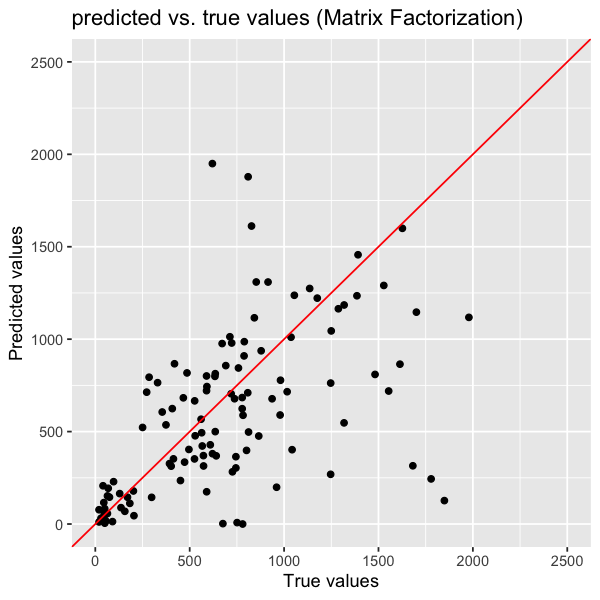

In [6]:
# テストデータにおける予測値と実測値の散布図
options(repr.plot.width = 5, repr.plot.height = 5)

df <- data.frame(as.vector(split$X_test), as.vector(pred))
df <- na.omit(df)
colnames(df) <- c("actual", "prediction")
p <- ggplot(df, aes(x = actual, y = prediction)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    xlim(0, 2500) +
    ylim(0, 2500) +
    labs(title = "predicted vs. true values (Matrix Factorization)", x = "True values", y = "Predicted values")
p


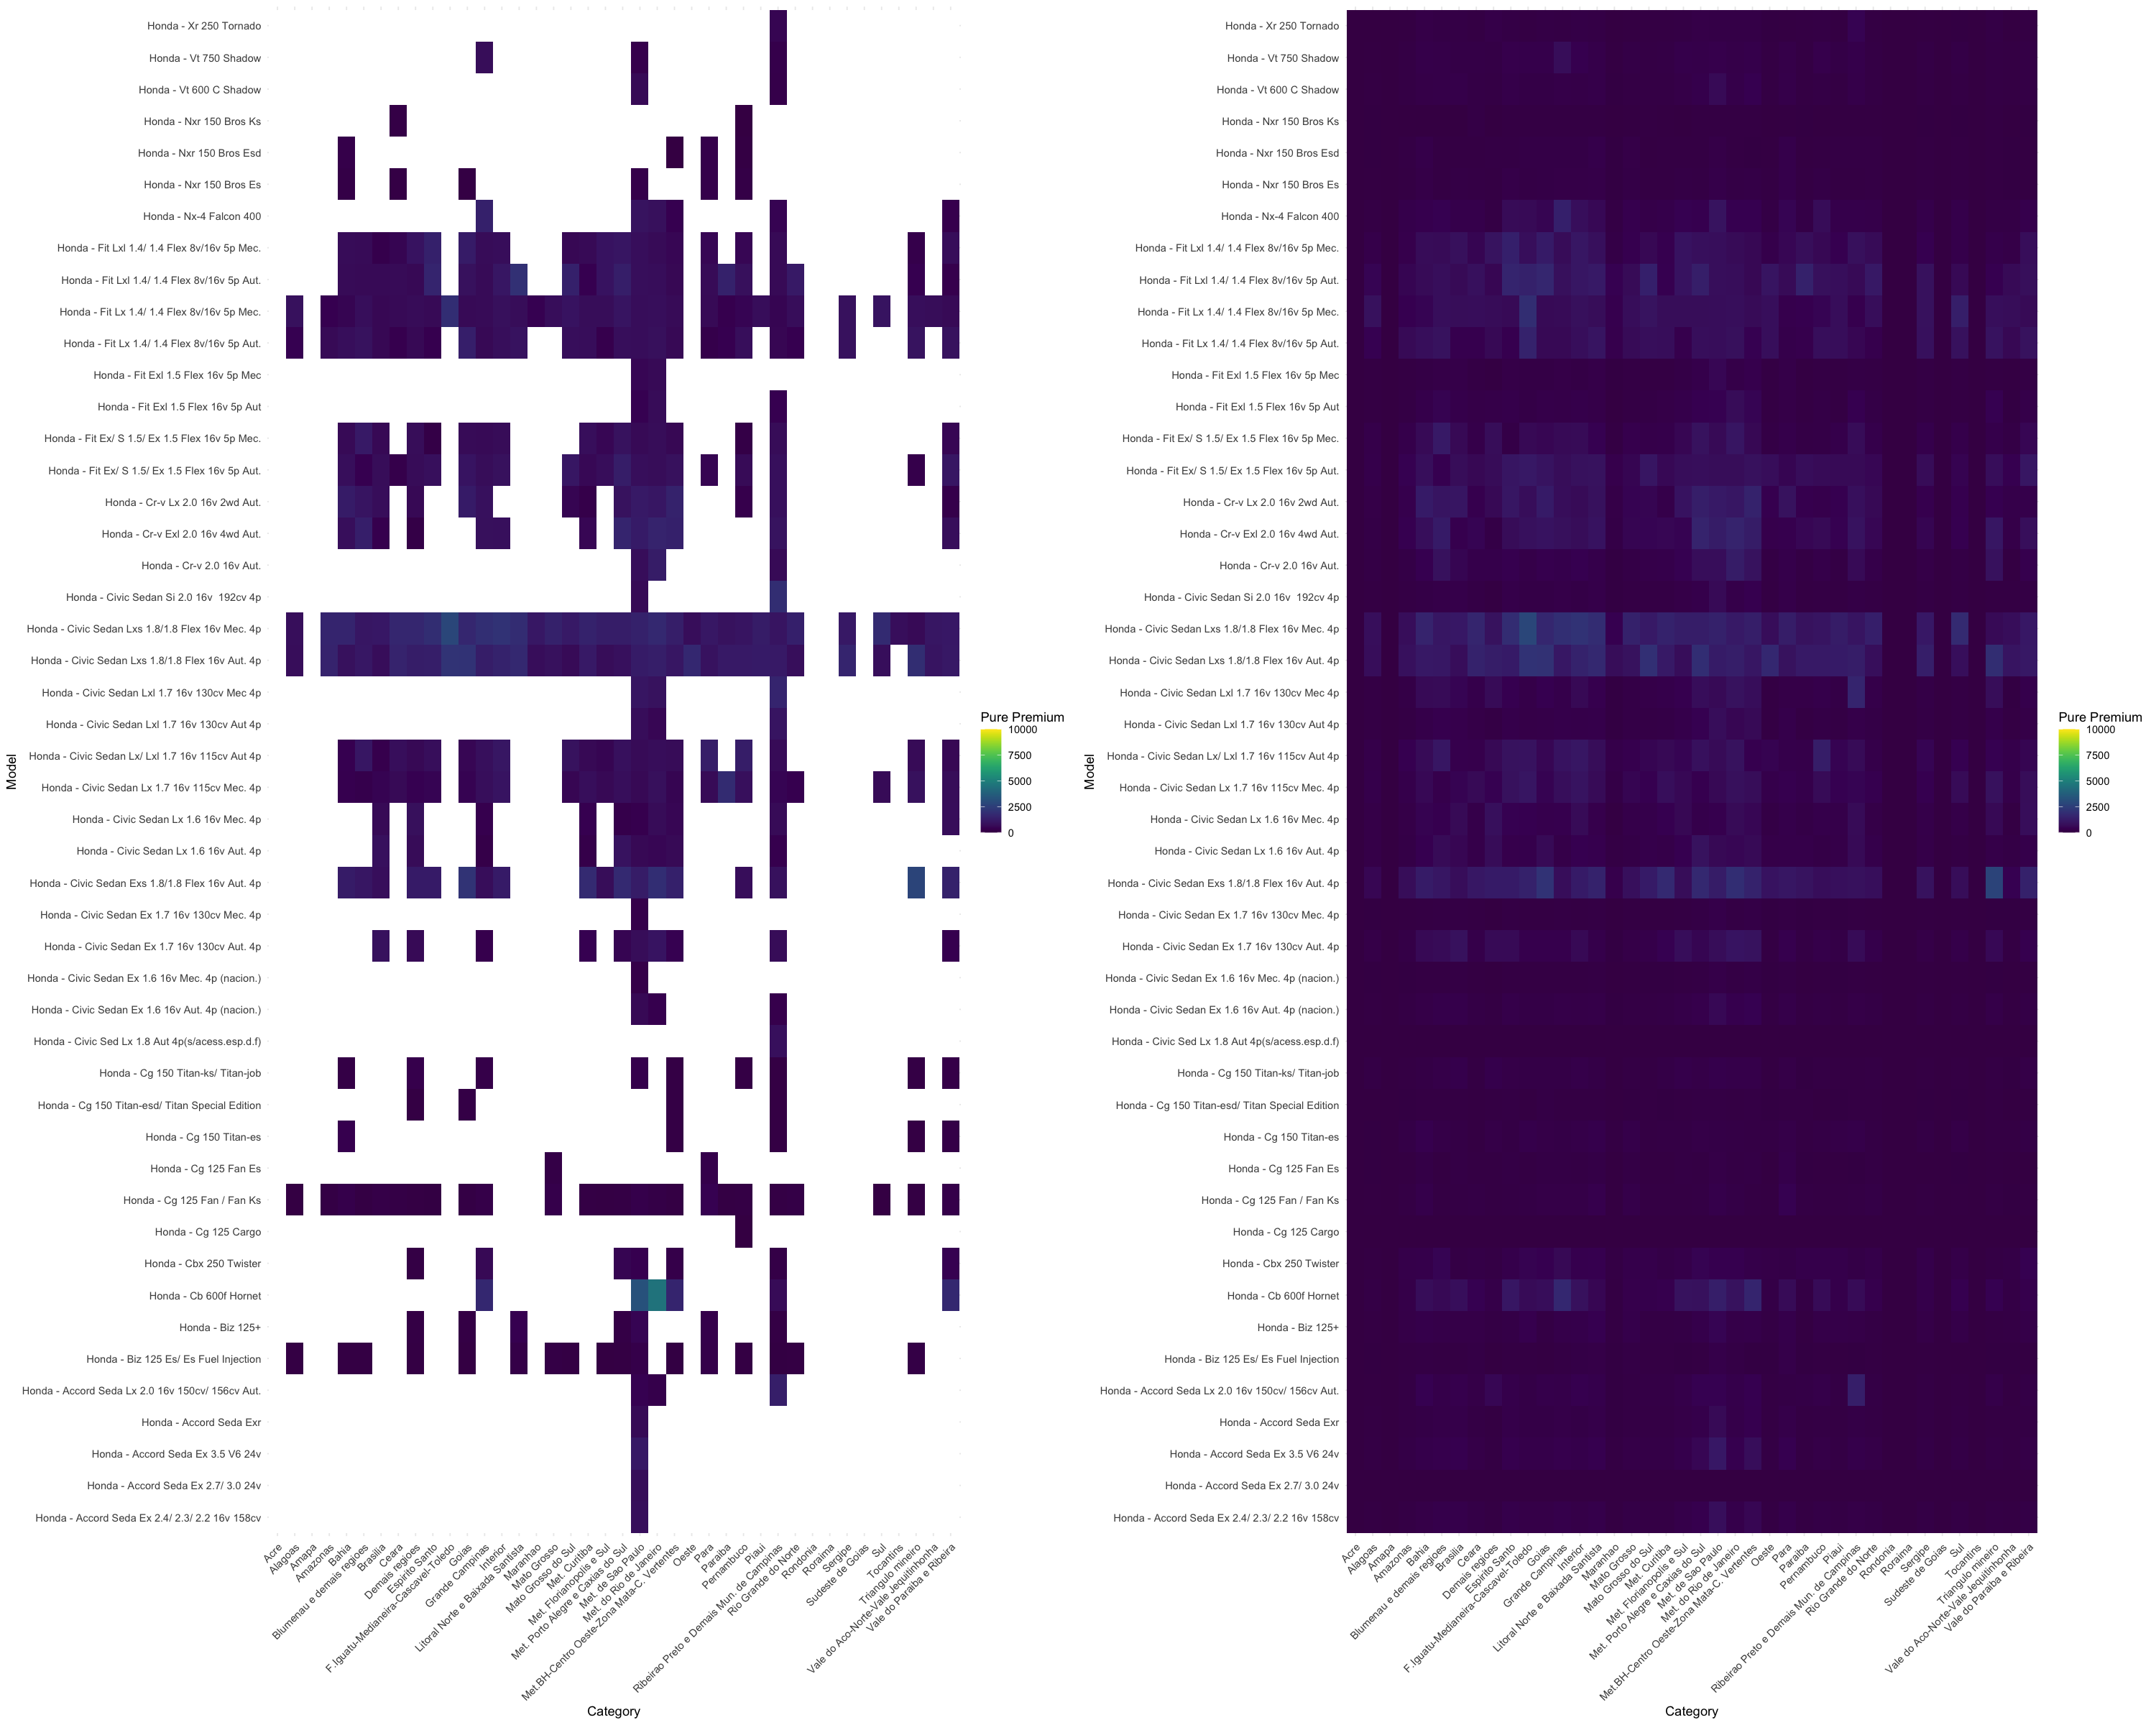

In [7]:
options(repr.plot.width = 25, repr.plot.height = 20)

# 全区分に対するヒートマップ（実績）
p1 <- visualize_heatmap(pure_premium)

# 全区分に対するヒートマップ（欠測を含む推定値）
actual <- pure_premium
actual[is.na(actual)] <- 0
estimated <- get_prediction(model, actual)
p2 <- visualize_heatmap(estimated)

grid.arrange(p1, p2, ncol = 2)


### 7. GLMとの比較

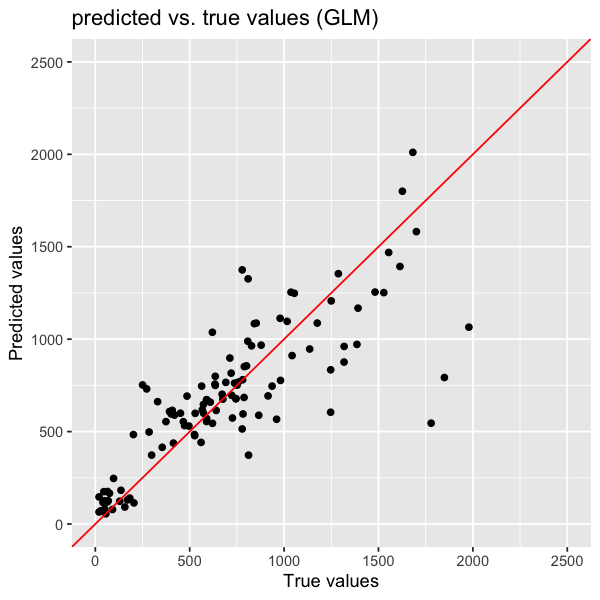

In [8]:
options(repr.plot.width = 5, repr.plot.height = 5)
exposure <- wide_to_long_format(exposure_total, c("VehModel", "Area", "exposure"), na_omit = FALSE)
# train <- wide_to_long_format(split$X_train, c("VehModel", "Area", "pure_premium"), na_omit = TRUE)

all_data <- wide_to_long_format(pure_premium, c("VehModel", "Area", "pure_premium"), na_omit = FALSE)
all_data <- merge(all_data, exposure, by = c("VehModel", "Area"))

test <- wide_to_long_format(split$X_test, c("VehModel", "Area", "pure_premium"), na_omit = TRUE)
# train <- merge(train, exposure, by = c("VehModel", "Area"))
test <- merge(test, exposure, by = c("VehModel", "Area"))

glm_model <- glm(pure_premium * exposure ~ VehModel + Area + offset(log(exposure)), data = all_data, family = poisson)

pred <- predict(glm_model, newdata = test, type = "response")
test[, "prediction"] <- pred / test[, "exposure"]
test <- na.omit(test)

df <- data.frame(as.vector(test$pure_premium), as.vector(test$prediction))
df <- na.omit(df)
colnames(df) <- c("actual", "prediction")
p <- ggplot(df, aes(x = actual, y = prediction)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    xlim(0, 2500) +
    ylim(0, 2500) +
    labs(title = "predicted vs. true values (GLM)", x = "True values", y = "Predicted values")
p

pred_all_data <- predict(glm_model, newdata = na.omit(all_data), type = "response")

row_ids <- row.names(na.omit(all_data))
all_data[, "prediction"] <- NA
all_data[row_ids, "prediction"] <- pred_all_data / all_data[row_ids, "exposure"]

# left join test to all_data
# all_data <- left_join(all_data, test, by = c("VehModel", "Area"))


In [9]:
print(colnames(all_data))

all_data_pred_wide_format <- get_total(all_data, category_to_analyze, "prediction", NA)


[1] "VehModel"     "Area"         "pure_premium" "exposure"     "prediction"  


aggregate_col: prediction   group_cols: VehModelArea



[1] 48 40


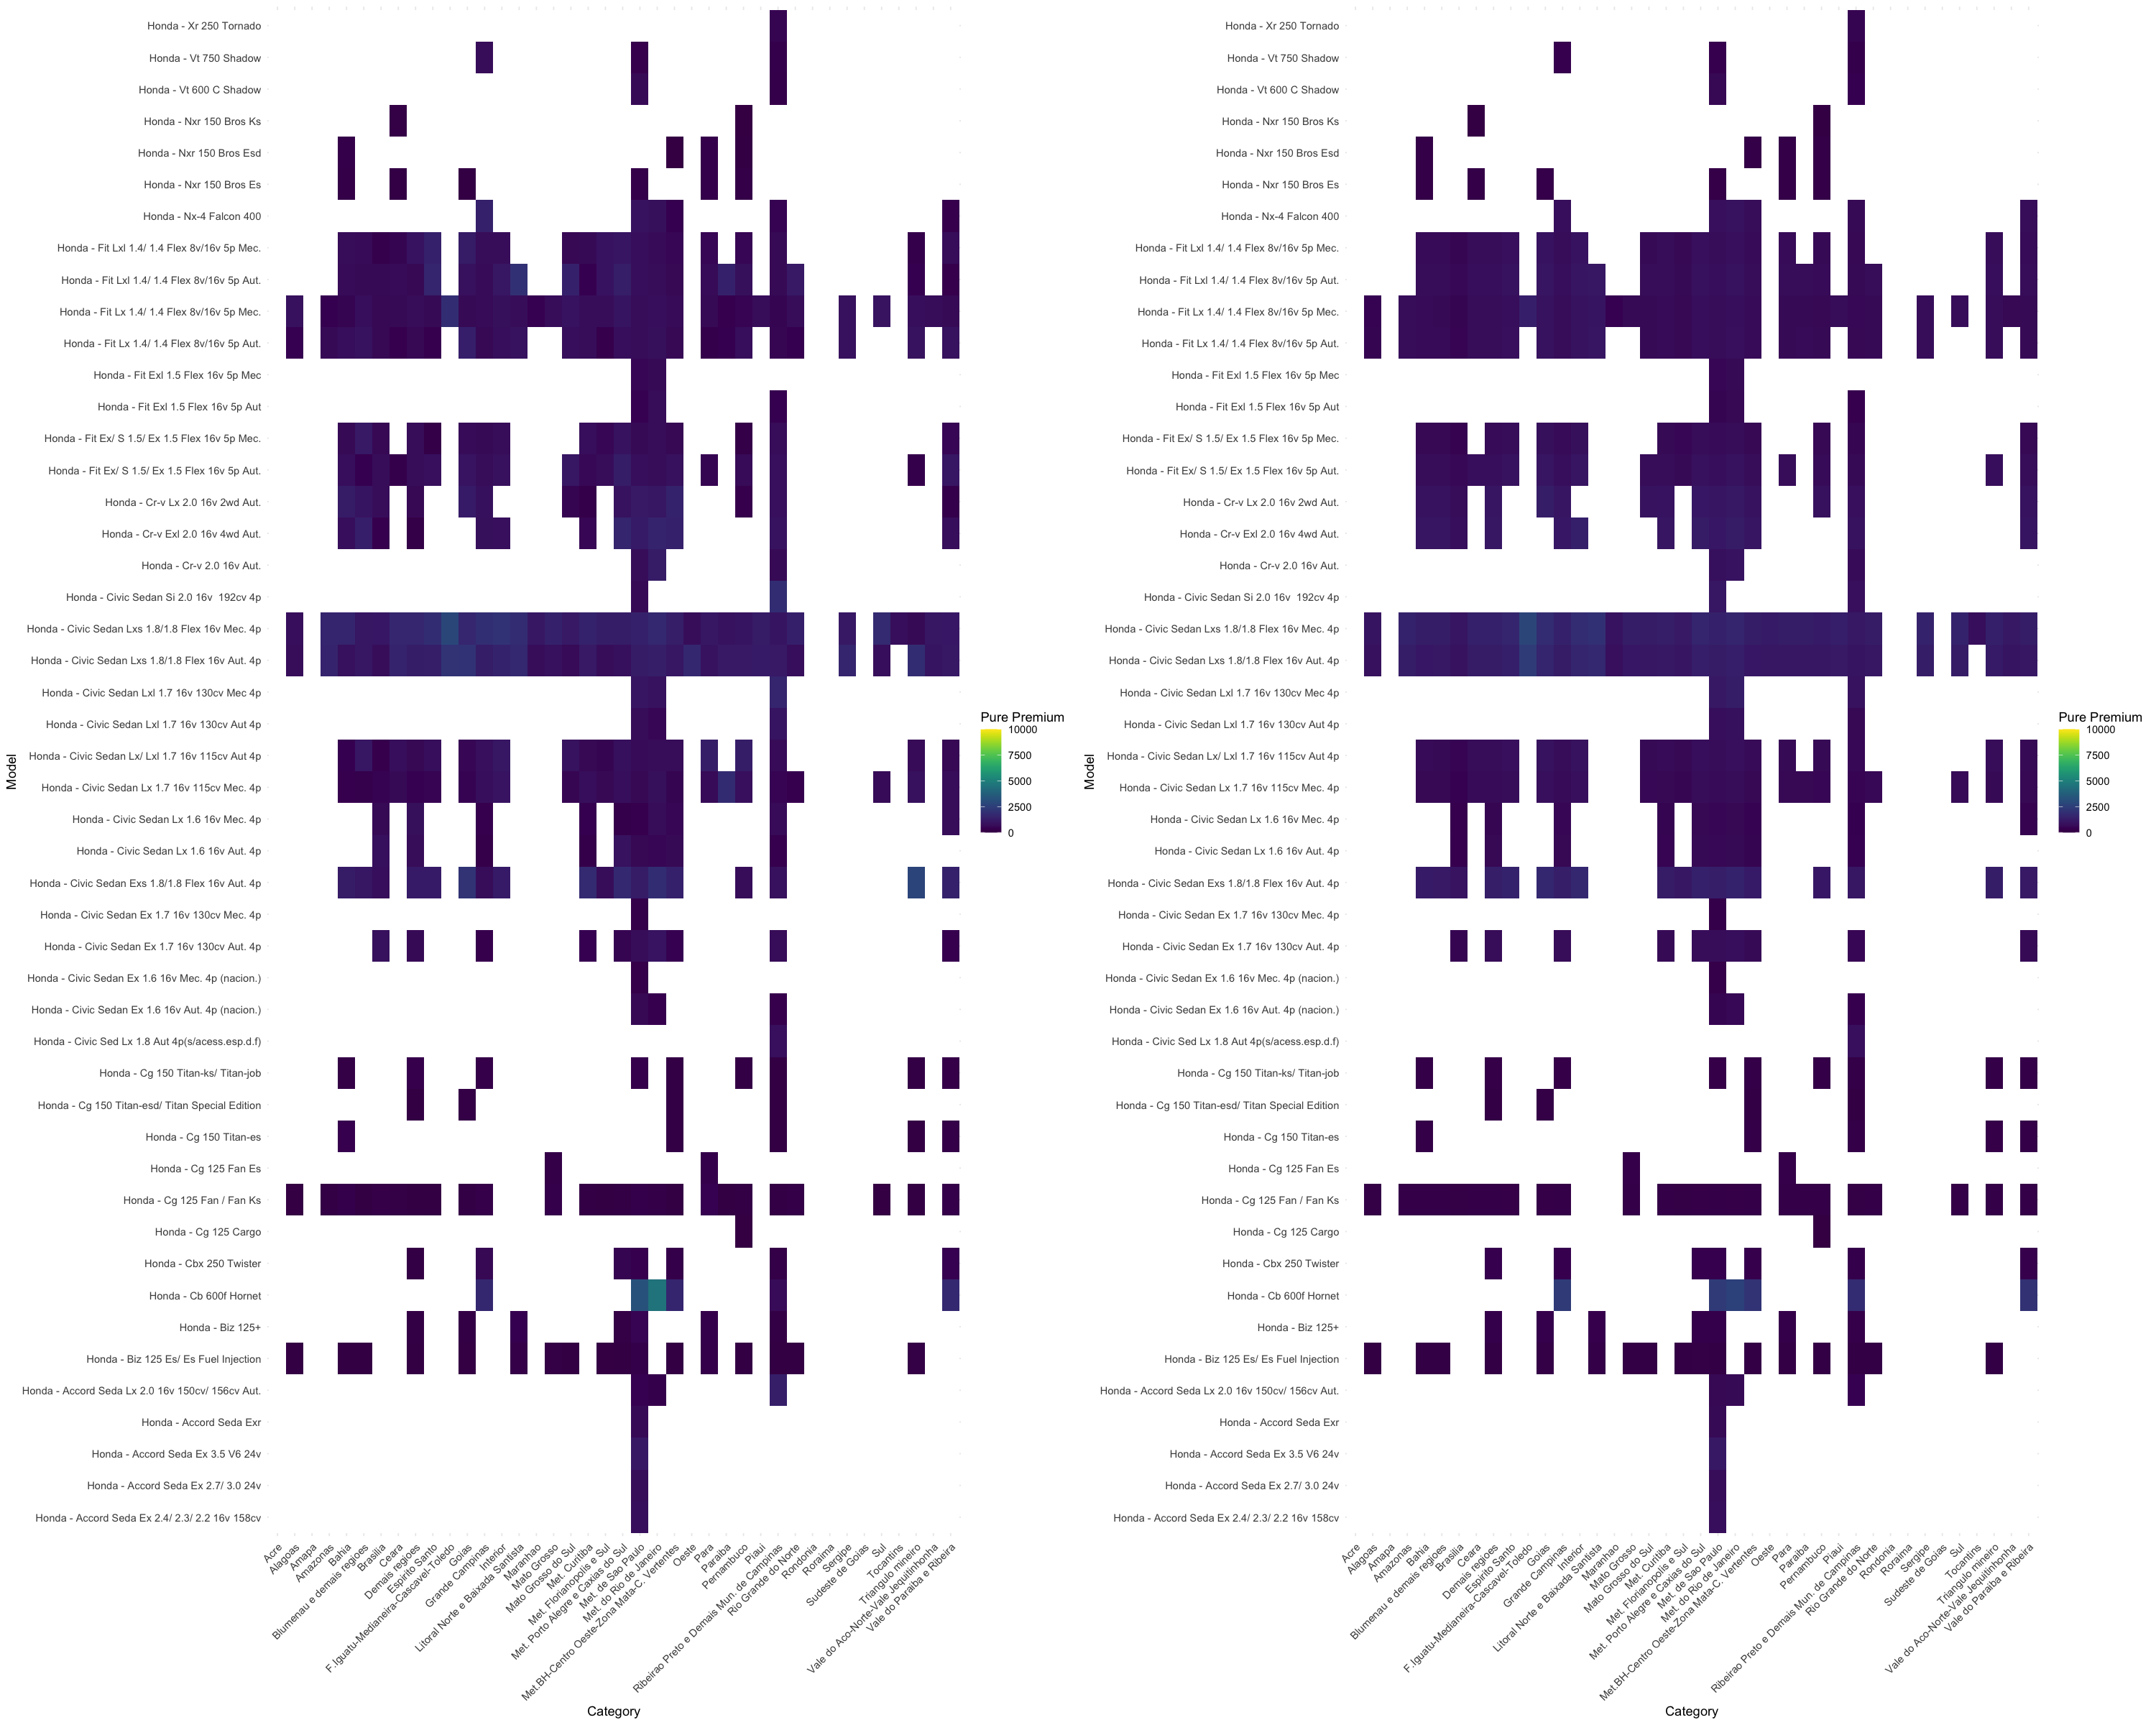

In [10]:
options(repr.plot.width = 25, repr.plot.height = 20)

# 全区分に対するヒートマップ（実績）
p1 <- visualize_heatmap(pure_premium)

# 全区分に対するヒートマップ（欠測を含む推定値）
actual <- pure_premium
actual[is.na(actual)] <- 0
estimated <- all_data_pred_wide_format # get_prediction(model, actual)

p2 <- visualize_heatmap(estimated)

grid.arrange(p1, p2, ncol = 2)
